# Matter-Antimatter asymmetries at the LHC

### Overview
This notebook contains an example analysis of LHCb open data from the University of Manchester undergraduate laboratory project on matter-antimatter asymmetries. Here we demonstrate an alternative implementation of the solution rewritten with ROOT.

In [1]:
import time
start_time = time.time()

import datetime
now = datetime.datetime.now()
print(f"Starting execution at: {now.hour}:{now.minute}")

Starting execution at: 16:18


In [2]:
import sys
print(sys.executable)
print(sys.version)

/opt/homebrew/Caskroom/miniconda/base/envs/myenv1/bin/python
3.14.2 | packaged by conda-forge | (main, Dec  6 2025, 11:34:40) [Clang 20.1.8 ]


### Configuration
The cell below imports all required Python modules.

In [3]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep  
import math


# Constants
mpi = 140.
mK = 494.
mD = 1865.
mJp = 3097.
mp2S = 3686.
mB = 5280.
probK_all = 0.5
probK_high = 0.8
probK_sum = 2.1
probK_max = 0.7
probpi_all = 0.6
probpi_sum2 = 1.3
probpi_sum = 2.4
mass_cut = 50.
mass_cut_D = 20.

### Input data
Creates a ROOT RDataFrame using the input data files we have.

In [4]:
# Enable RDataFrame implicit multi-threading
# ROOT.EnableImplicitMT()

# Open the files needed for the analysis
tree_name = "DecayTree"
input_files = [
    "../data/B2HHH_MagnetDown.root",
    "../data/B2HHH_MagnetUp.root",
]
    
df = ROOT.RDataFrame("DecayTree", input_files)

# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(df.GetColumnNames())

Input data variables:
{ "B_FlightDistance", "B_VertexChi2", "H1_Charge", "H1_IPChi2", "H1_PX", "H1_PY", "H1_PZ", "H1_ProbK", "H1_ProbPi", "H1_isMuon", "H2_Charge", "H2_IPChi2", "H2_PX", "H2_PY", "H2_PZ", "H2_ProbK", "H2_ProbPi", "H2_isMuon", "H3_Charge", "H3_IPChi2", "H3_PX", "H3_PY", "H3_PZ", "H3_ProbK", "H3_ProbPi", "H3_isMuon" }


### Select data and calculate derived quantities
The following cells reads the input data. This is where all derived quantities (such as transverse momentum) should are calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [5]:
# Python helpers
def pt(px, py):
    return math.sqrt(px*px + py*py)

def make_energy(mass):
    m2 = mass * mass
    return lambda px, py, pz: math.sqrt(px*px + py*py + pz*pz + m2)

E_pi = make_energy(mpi)
E_K  = make_energy(mK)

def p2sum_sq(px1, py1, pz1, px2, py2, pz2):
    sx = px1 + px2
    sy = py1 + py2
    sz = pz1 + pz2
    return sx*sx + sy*sy + sz*sz

def p3sum_sq(px1, py1, pz1, px2, py2, pz2, px3, py3, pz3):
    sx = px1 + px2 + px3
    sy = py1 + py2 + py3
    sz = pz1 + pz2 + pz3
    return sx*sx + sy*sy + sz*sz

def inv_m2_two(E1, E2, p12sq):
    sE = E1 + E2
    return sE*sE - p12sq

def inv_m_three(E1, E2, E3, psq):
    sE = E1 + E2 + E3
    m2 = sE*sE - psq
    return math.sqrt(m2)

In [6]:
# Calculate derived quantities
for i in (1, 2, 3):
    df = (
        df.Define(f"pT_H{i}", pt, [f"H{i}_PX", f"H{i}_PY"])
        .Define(f"e_pi{i}", E_pi, [f"H{i}_PX", f"H{i}_PY", f"H{i}_PZ"])
        .Define(f"e_K{i}",  E_K,  [f"H{i}_PX", f"H{i}_PY", f"H{i}_PZ"])
    )

df = (
    df.Define("p12sq", p2sum_sq, ["H1_PX","H1_PY","H1_PZ","H2_PX","H2_PY","H2_PZ"])
    .Define("p23sq", p2sum_sq, ["H2_PX","H2_PY","H2_PZ","H3_PX","H3_PY","H3_PZ"])
    .Define("p13sq", p2sum_sq, ["H1_PX","H1_PY","H1_PZ","H3_PX","H3_PY","H3_PZ"])
    .Define("psq",   p3sum_sq, ["H1_PX","H1_PY","H1_PZ","H2_PX","H2_PY","H2_PZ","H3_PX","H3_PY","H3_PZ"])
)

df = (
    df.Define("m12KKsq",    inv_m2_two, ["e_K1",  "e_K2",  "p12sq"])
      .Define("m23KKsq",    inv_m2_two, ["e_K3",  "e_K2",  "p23sq"])
      .Define("m13KKsq",    inv_m2_two, ["e_K1",  "e_K3",  "p13sq"])
      .Define("m12pipisq",  inv_m2_two, ["e_pi1", "e_pi2", "p12sq"])
      .Define("m23pipisq",  inv_m2_two, ["e_pi3", "e_pi2", "p23sq"])
      .Define("m13pipisq",  inv_m2_two, ["e_pi1", "e_pi3", "p13sq"])
      .Define("m12Kpisq",   inv_m2_two, ["e_K1",  "e_pi2", "p12sq"])
      .Define("m23Kpisq",   inv_m2_two, ["e_K3",  "e_pi2", "p23sq"])
      .Define("m13Kpisq",   inv_m2_two, ["e_K1",  "e_pi3", "p13sq"])
      .Define("m12piKsq",   inv_m2_two, ["e_pi1", "e_K2",  "p12sq"])
      .Define("m23piKsq",   inv_m2_two, ["e_pi3", "e_K2",  "p23sq"])
      .Define("m13piKsq",   inv_m2_two, ["e_pi1", "e_K3",  "p13sq"])
)

df = (
    df.Define("mKKKinv",     inv_m_three, ["e_K1",  "e_K2",  "e_K3",  "psq"])
      .Define("mpipipiinv",  inv_m_three, ["e_pi1", "e_pi2", "e_pi3", "psq"])
      .Define("mKpipiinv",   inv_m_three, ["e_K1",  "e_pi2", "e_pi3", "psq"])
      .Define("mpiKpiinv",   inv_m_three, ["e_pi1", "e_K2",  "e_pi3", "psq"])
      .Define("mpipiKinv",   inv_m_three, ["e_pi1", "e_pi2", "e_K3",  "psq"])
)

print(f'Read {df.Count().GetValue()} events.')

Read 8556118 events.


In [7]:
# Decide here which events to analyse
def all_positive_pz(pz1, pz2, pz3):
    return (pz1 >= 0) and (pz2 >= 0) and (pz3 >= 0)

def none_is_muon(m1, m2, m3):
    return (not m1) and (not m2) and (not m3)

df_derived = (
    df.Filter(all_positive_pz, ["H1_PZ", "H2_PZ", "H3_PZ"], "Positive PZ")
      .Filter(none_is_muon, ["H1_isMuon", "H2_isMuon", "H3_isMuon"], "Not muons")
)

In [8]:
# General helpers
def low_sq(q1,q2,q3, m12, m13, m23):
    if q1 == q2:
        ret = min(m13, m23)
    elif q1 == q3:
        ret = min(m12, m23)
    elif q2 == q3:
        ret = min(m12, m13)
    else: return -999.0
    return ret

def high_sq(q1, q2, q3, m12, m13, m23):
    if q1 == q2:
        ret = max(m13, m23)
    elif q1 == q3:
        ret = max(m12, m23)
    elif q2 == q3:
        ret = max(m12, m13)
    else:
        return -999.0
    return ret

def in_window(m):
    return abs(m - mB) < mass_cut

def pass_dveto(m_low):
    return abs(m_low - mD) > mass_cut_D

def define_m(condition1, condition2, m):
    return m if (condition1 and condition2) else -999.0

In [9]:
# KKK Helpers
def is_kkk(p1, p2, p3):
    return (p1 > probK_all) and (p2 > probK_all) and (p3 > probK_all) and ((p1 + p2 + p3) > probK_sum)

In [10]:
# KKK selection
df_derived = (
    df_derived.Define("is_KKK_candidate", is_kkk, ["H1_ProbK","H2_ProbK","H3_ProbK"])
    .Define("KK_low_sq",  low_sq,  ["H1_Charge","H2_Charge","H3_Charge","m12KKsq","m13KKsq","m23KKsq"])
    .Define("KK_high_sq", high_sq, ["H1_Charge","H2_Charge","H3_Charge","m12KKsq","m13KKsq","m23KKsq"])
    .Define("KKK_in_B_window", in_window, ["mKKKinv"])
    .Define("KKK_pass_D_veto", pass_dveto, ["KK_low_sq"])
    .Define("m_KKK", define_m, ["is_KKK_candidate", "KKK_pass_D_veto", "mKKKinv"])
    .Define("mKKlow", define_m, ["is_KKK_candidate", "KKK_in_B_window", "KK_low_sq"])
    .Define("mKKhigh", define_m, ["is_KKK_candidate", "KKK_in_B_window", "KK_high_sq"])
)

In [11]:
# KKK df
df_kkk = df_derived.Filter(
    "is_KKK_candidate",
    "KKK candidates"
)

df_kkk_mass_window = df_kkk.Filter(
    "KKK_in_B_window",
    "KKK in B mass window"
)

df_kkk_selected = df_kkk.Filter(
    "m_KKK > 0",
    "KKK selected (valid mass)"
)

In [12]:
# KKK counters
kkk_candidates  = df_kkk.Count()
kkk_mass_window = df_kkk_mass_window.Count()
kkk_selected    = df_kkk_selected.Count()

In [13]:
# πππ Helpers
def is_pipipi(p1, p2, p3, p4, p5, p6):
    return (
        (p1 > probpi_all) and (p2 > probpi_all) and (p3 > probpi_all)
        and (p4 < probK_max) and (p5 < probK_max) and (p6 < probK_max)
        and ((p1 + p2 + p3) > probpi_sum))

def pi_pass_dveto(pipipi_low, pipipi_high):
    return (abs(pipipi_low - mD) > mass_cut_D) and (abs(pipipi_high - mD) > mass_cut_D)

In [14]:
# πππ selection
df_derived = (
    df_derived.Define("is_PIPIPI_candidate", is_pipipi, ["H1_ProbPi", "H2_ProbPi", "H3_ProbPi", "H1_ProbK", "H2_ProbK", "H3_ProbK"],)
    .Define("PIPIPI_low_sq",  low_sq,  ["H1_Charge","H2_Charge","H3_Charge","m12pipisq","m13pipisq","m23pipisq"])
    .Define("PIPIPI_high_sq", high_sq, ["H1_Charge","H2_Charge","H3_Charge","m12pipisq","m13pipisq","m23pipisq"])
    .Define("PIPIPI_in_B_window", in_window, ["mpipipiinv"])
    .Define("PIPIPI_pass_D_veto", pi_pass_dveto, ["PIPIPI_low_sq", "PIPIPI_high_sq"])
    .Define("m_pipipi", define_m, ["is_PIPIPI_candidate", "PIPIPI_pass_D_veto", "mpipipiinv"])
    .Define("mpipilow", define_m, ["is_PIPIPI_candidate", "PIPIPI_in_B_window", "PIPIPI_low_sq"])
    .Define("mpipihigh", define_m, ["is_PIPIPI_candidate", "PIPIPI_in_B_window", "PIPIPI_high_sq"])
)

In [15]:
# πππ df
df_pipipi = df_derived.Filter(
    "is_PIPIPI_candidate",
    "PIPIPI_candidates"
)

df_pipipi_mass_window = df_pipipi.Filter(
    "PIPIPI_in_B_window",
    "PIPIPI_mass_window"
)

df_pipipi_selected = df_pipipi.Filter(
    "m_pipipi > 0",
    "PIPIPI_selected"
)

In [16]:
# πππ counters
pipipi_candidates   = df_pipipi.Count()
pipipi_mass_window  = df_pipipi_mass_window.Count()
pipipi_selected     = df_pipipi_selected.Count()

In [17]:
# Kππ Helpers
def identify_kpipi(k_prob1, k_prob2, k_prob3,
                   charge1, charge2, charge3,
                   pi_prob1, pi_prob2, pi_prob3):
    max_k_prob = max(k_prob1, k_prob2, k_prob3)
    # K = track 1
    if (
        k_prob1 == max_k_prob and k_prob1 > probK_high
        and charge2 != charge3
        and pi_prob2 > probpi_all and pi_prob3 > probpi_all
        and (pi_prob2 + pi_prob3) > probpi_sum2
    ):
        return 1
    # K = track 2
    if (
        k_prob2 == max_k_prob and k_prob2 > probK_high
        and charge1 != charge3
        and pi_prob1 > probpi_all and pi_prob3 > probpi_all
        and (pi_prob1 + pi_prob3) > probpi_sum2
    ):
        return 2
    # K = track 3
    if (
        k_prob3 == max_k_prob and k_prob3 > probK_high
        and charge1 != charge2
        and pi_prob1 > probpi_all and pi_prob2 > probpi_all
        and (pi_prob1 + pi_prob2) > probpi_sum2
    ):
        return 3
    return 0

def m_kpipi(k_track, mkpipi, mpikpi, mpipik):
    if k_track == 1:
        return mkpipi
    elif k_track == 2:
        return mpikpi
    elif k_track == 3:
        return mpipik
    else:
        return -999.0
    
def kpi_mass_sq(
    k_track,
    charge1, charge2, charge3,
    kpi_12, kpi_13, kpi_23,
    pik_12, pik_13, pik_23):

    k_track = int(k_track)
    if k_track == 1:
        return kpi_12 if charge2 != charge3 else kpi_13
    if k_track == 2:
        return pik_12 if charge2 != charge1 else kpi_23
    if k_track == 3:
        return pik_13 if charge3 != charge1 else pik_23
    return -999.0

def pipi_mass_sq(k_track, pipi_23, pipi_13, pipi_12):
    if k_track == 1:
        return pipi_23
    if k_track == 2:
        return pipi_13
    if k_track == 3:
        return pipi_12

    return -999.0

def define_m_kpi(k_track, in_win, m):
    return m if (k_track > 0 and in_win) else -999.0

df_derived = df_derived.Define("Kpipi_K_track", identify_kpipi, [
    "H1_ProbK", "H2_ProbK", "H3_ProbK",
    "H1_Charge", "H2_Charge", "H3_Charge",
    "H1_ProbPi", "H2_ProbPi", "H3_ProbPi",
])

In [18]:
# Kππ selection
df_derived = (
    df_derived.Define("m_Kpipi", m_kpipi, ["Kpipi_K_track", "mKpipiinv", "mpiKpiinv", "mpipiKinv"])
    .Define("mKpi_sq", kpi_mass_sq, [
        "Kpipi_K_track",
        "H1_Charge", "H2_Charge", "H3_Charge",
        "m12Kpisq", "m13Kpisq", "m23Kpisq",
        "m12piKsq", "m13piKsq", "m23piKsq"])
    .Define("mpipi_sq", pipi_mass_sq, ["Kpipi_K_track", "m23pipisq", "m13pipisq", "m12pipisq"])
    .Define("Kpipi_in_B_window", in_window, ["m_Kpipi"])
    .Define("Kpipi_pass_D_veto", pass_dveto, ["mKpi_sq"])
    .Define("mKpi", define_m_kpi, ["Kpipi_K_track", "Kpipi_in_B_window", "mKpi_sq"])
    .Define("mpipi", define_m_kpi, ["Kpipi_K_track", "Kpipi_in_B_window", "mpipi_sq"])
)

In [19]:
# Kππ df
df_kpi = df_derived.Filter(
    "Kpipi_K_track > 0",
    "Kππ candidates"
)

df_kpi_mass_window = df_kpi.Filter(
    "Kpipi_in_B_window",
    "Kππ in B mass window"
)

df_kpi_selected = df_kpi.Filter(
    "m_Kpipi > 0",
    "Kππ selected"
)

In [20]:
# Kππ counters
kpi_candidates   = df_kpi.Count()
kpi_mass_window  = df_kpi_mass_window.Count()
kpi_selected     = df_kpi_selected.Count()

### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

In [21]:
# Python helpers
def define_m_sqrt(m):
    return math.sqrt(m) if m > 0 else -999.0

In [22]:
df_kkk_mass_window = (
    df_kkk_mass_window.Define("KKK_mlow_sqrt", define_m_sqrt, ["mKKlow"])
    .Define("KKK_mhigh_sqrt", define_m_sqrt, ["mKKhigh"])
)

df_pipipi_mass_window = (
    df_pipipi_mass_window.Define("PIPIPI_mlow_sqrt", define_m_sqrt, ["mpipilow"])
    .Define("PIPIPI_mhigh_sqrt", define_m_sqrt, ["mpipihigh"])
)

df_kpi_mass_window = (
    df_kpi_mass_window.Define("kpi_mKpi_sqrt", define_m_sqrt, ["mKpi"])
    .Define("kpi_mpipi_sqrt", define_m_sqrt, ["mpipi"])
)

h_mKKlow = df_kkk_mass_window.Histo1D(("h_mKKlow", "KK low mass", 500, 200, 5200), "KKK_mlow_sqrt")
h_mKKhigh = df_kkk_mass_window.Histo1D(("h_mKKhigh", "KK high mass", 500, 200, 5200), "KKK_mhigh_sqrt")
h_mKKK = df_kkk_selected.Histo1D(("h_mKKK", "KKK mass", 300, 4500, 6000), "m_KKK")

h_mpipilow = df_pipipi_mass_window.Histo1D(("h_mpipilow", "ππ low mass", 500, 200, 5200), "PIPIPI_mlow_sqrt")
h_mpipihigh = df_pipipi_mass_window.Histo1D(("h_mpipihigh", "ππ high mass", 500, 200, 5200), "PIPIPI_mhigh_sqrt")
h_mpipipi = df_pipipi_selected.Histo1D(("h_mpipipi", "πππ mass", 150, 4500, 6000), "m_pipipi")

h_mKpipi = df_kpi_selected.Histo1D(("h_mKpipi", "Kππ mass", 300, 4500, 6000), "m_Kpipi")
h_mKpi = df_kpi_mass_window.Histo1D(("h_mKpi", "Kπ mass", 500, 200, 5200), "kpi_mKpi_sqrt")
h_mpipi = df_kpi_mass_window.Histo1D(("h_mpipi", "ππ mass in Kππ", 500, 200, 5200), "kpi_mpipi_sqrt")    

h_mKKK_narrow = df_kkk_selected.Histo1D(("h_mKKK_narrow", "KKK mass narrow", 300, 5000, 5600), "m_KKK")
h_mpipipi_narrow = df_pipipi_selected.Histo1D(("h_mpipipi_narrow", "πππ mass narrow", 300, 5000, 5600), "m_pipipi")
h_mKpipi_narrow = df_kpi_selected.Histo1D(("h_mKpipi_narrow", "Kππ mass narrow", 300, 5000, 5600), "m_Kpipi")


In [23]:
# Counts Report
total_events_val = df.Count().GetValue()
basic_events_val = df_derived.Count().GetValue()
kkk_candidates_val = kkk_candidates.GetValue()
kkk_selected_val = kkk_selected.GetValue()
pipipi_candidates_val = pipipi_candidates.GetValue()
pipipi_selected_val = pipipi_selected.GetValue()
kpi_candidates_val = kpi_candidates.GetValue()
kpi_selected_val = kpi_selected.GetValue()
kkk_mass_window_val = kkk_mass_window.GetValue()
pipipi_mass_window_val = pipipi_mass_window.GetValue()
kpi_mass_window_val = kpi_mass_window.GetValue()

print(f"\nEvent selection completed. Processed {total_events_val} events in total.")
print(f"Events after basic cuts: {basic_events_val}")
print(f"KKK candidates: {kkk_candidates_val}, selected: {kkk_selected_val}")
print(f"πππ candidates: {pipipi_candidates_val}, selected: {pipipi_selected_val}")
print(f"Kππ candidates: {kpi_candidates_val}, selected: {kpi_selected_val}")

print("\n=== DETAILED SELECTION REPORT ===")
if kkk_candidates_val > 0:
    print(f"KKK selection efficiency: {kkk_selected_val/kkk_candidates_val*100:.2f}% ({kkk_selected_val}/{kkk_candidates_val})")
if pipipi_candidates_val > 0:
    print(f"πππ selection efficiency: {pipipi_selected_val/pipipi_candidates_val*100:.2f}% ({pipipi_selected_val}/{pipipi_candidates_val})")
if kpi_candidates_val > 0:
    print(f"Kππ selection efficiency: {kpi_selected_val/kpi_candidates_val*100:.2f}% ({kpi_selected_val}/{kpi_candidates_val})")


Event selection completed. Processed 8556118 events in total.
Events after basic cuts: 6311517
KKK candidates: 23701, selected: 23701
πππ candidates: 448685, selected: 448685
Kππ candidates: 286813, selected: 286813

=== DETAILED SELECTION REPORT ===
KKK selection efficiency: 100.00% (23701/23701)
πππ selection efficiency: 100.00% (448685/448685)
Kππ selection efficiency: 100.00% (286813/286813)


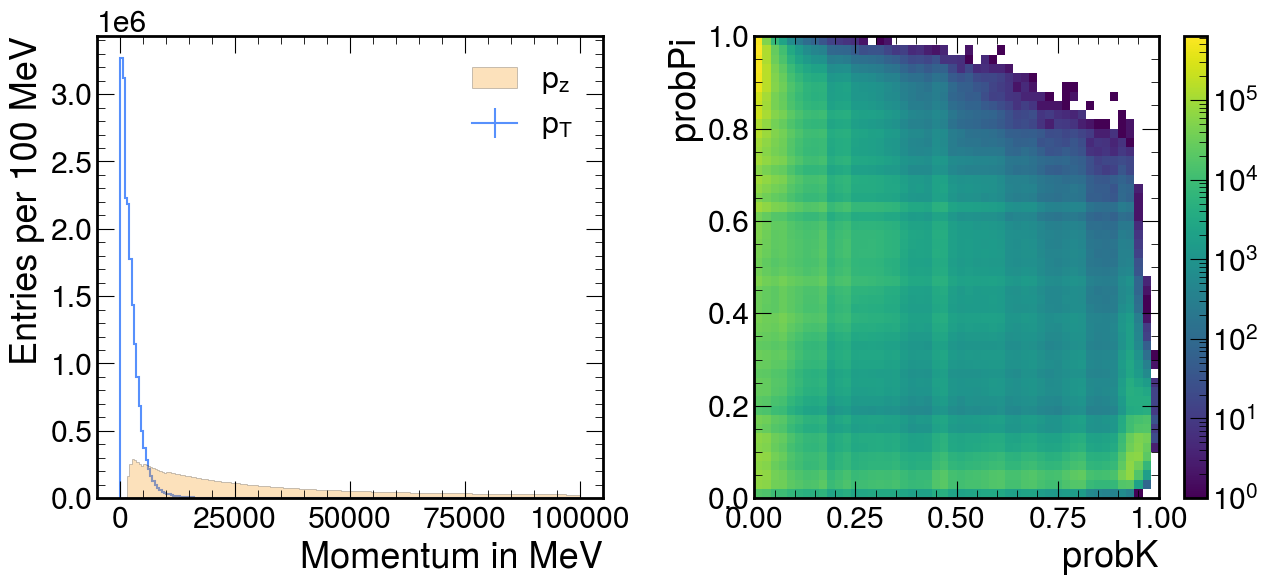

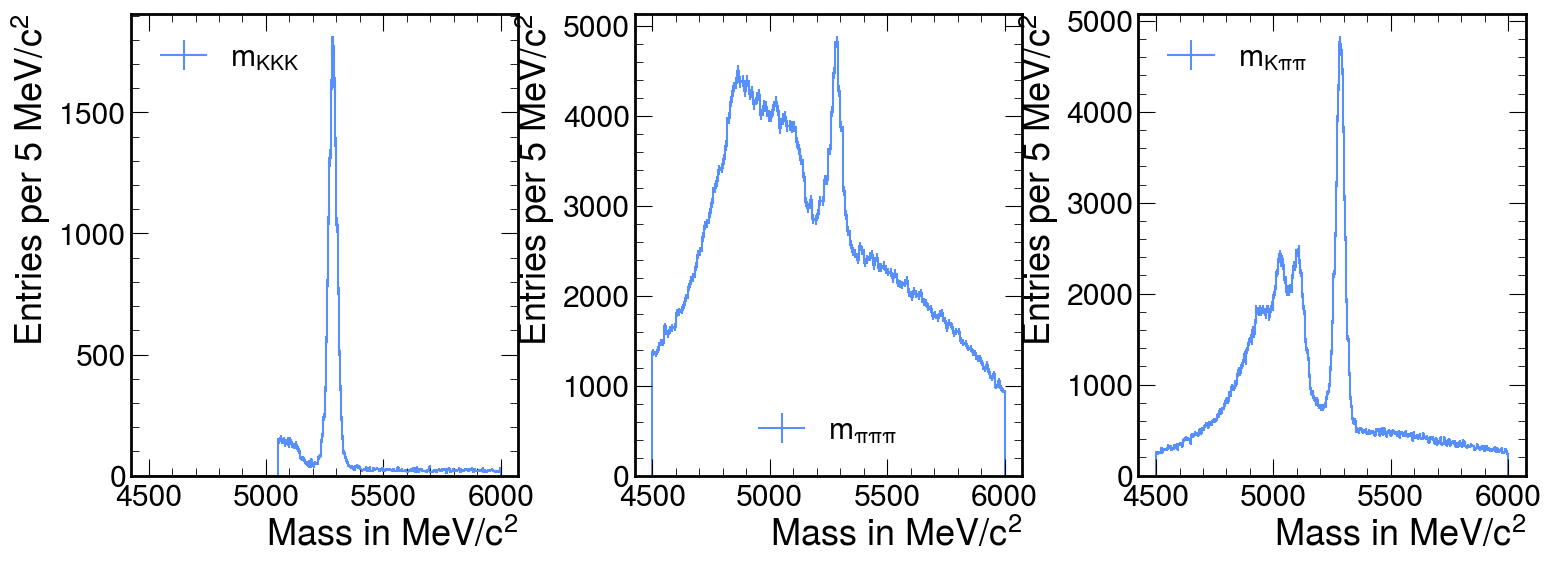

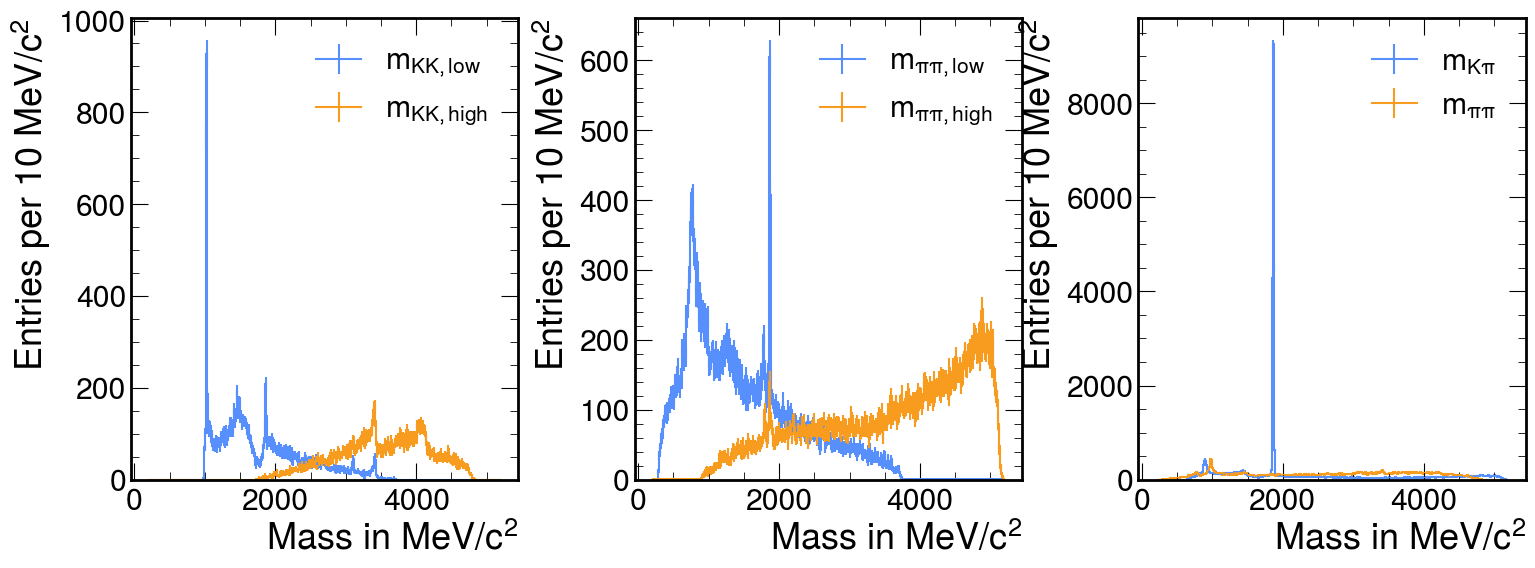

In [24]:
# Plot some histograms
h_pT = ROOT.TH1F("h_pT", "p_{T} Distribution", 200, 0, 100000)
for col in ["pT_H1", "pT_H2", "pT_H3"]:
    h_temp = df_derived.Histo1D((f"h_{col}", col, 200, 0, 100000), col).GetValue()
    h_pT.Add(h_temp)

h_pZ = ROOT.TH1F("h_pZ", "p_{z} Distribution", 200, 0, 100000)
for col in ["H1_PZ", "H2_PZ", "H3_PZ"]:
    h_temp = df_derived.Histo1D((f"h_{col}", col, 200, 0, 100000), col).GetValue()
    h_pZ.Add(h_temp)


h2d_prob = ROOT.TH2F("h2d_prob", "probK vs probPi;probK;probPi", 50, 0, 1, 50, 0, 1)
for h1, h2 in zip(["H1_ProbK", "H2_ProbK", "H3_ProbK"], ["H1_ProbPi", "H2_ProbPi", "H3_ProbPi"]):
    h_temp = df_derived.Histo2D((f"h2d_{h1}_{h2}", f"{h1} vs {h2}", 50, 0, 1, 50, 0, 1), h1, h2).GetValue()
    h2d_prob.Add(h_temp)

# First line of plots
# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
plt.style.use(hep.style.ROOT)
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig1.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
hep.histplot([h_pT], ax=ax1[0], histtype='step', label='$p_{T}$', linewidth=1.5)
hep.histplot([h_pZ], ax=ax1[0], histtype='fill', label='$p_{z}$', alpha=0.3, edgecolor='black', linewidth=0.5)
ax1[0].set_xlabel('Momentum in MeV')
ax1[0].set_ylabel('Entries per 100 MeV')
ax1[0].legend()
plt.savefig('../outputs/pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
# hep.hist2dplot(h2d_prob.values(), ax=ax[1], norm=colors.LogNorm())
x_bins = np.linspace(0, 1, 51)
y_bins = np.linspace(0, 1, 51)
z_data = np.array([[h2d_prob.GetBinContent(i, j) for j in range(1, 51)] 
                    for i in range(1, 51)])
im = ax1[1].pcolormesh(x_bins, y_bins, z_data.T, norm=colors.LogNorm(vmin=1), shading='auto')
plt.colorbar(im, ax=ax1[1])
ax1[1].set_xlabel('probK')
ax1[1].set_ylabel('probPi')
plt.savefig('../outputs/probKpi.pdf')


# Second line of plots
fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig2.subplots_adjust(wspace=0.3) # increase horizontal space between plots
mass_configs = [
    (h_mKKK.GetValue(), kkk_selected_val, r'$m_{KKK}$', ax2[0], "KKK Mass Distribution"),
    (h_mpipipi.GetValue(), pipipi_selected_val, r'$m_{\pi\pi\pi}$', ax2[1], "πππ Mass Distribution"),
    (h_mKpipi.GetValue(), kpi_selected_val, r'$m_{K\pi\pi}$', ax2[2], "Kππ Mass Distribution")
]
for hist_value, count, label, ax, desc in mass_configs:
    hep.histplot(hist_value, ax=ax, histtype='step', label=label)

ax2[0].set_xlabel('Mass in MeV/$c^2$')
ax2[0].set_ylabel('Entries per 5 MeV/$c^2$')
ax2[0].legend()
plt.savefig('../outputs/mKKK.pdf')
ax2[1].set_xlabel('Mass in MeV/$c^2$')
ax2[1].set_ylabel('Entries per 5 MeV/$c^2$')
ax2[1].legend()
plt.savefig('../outputs/mpipipi.pdf')
ax2[2].set_xlabel('Mass in MeV/$c^2$')
ax2[2].set_ylabel('Entries per 5 MeV/$c^2$')
ax2[2].legend()
plt.savefig('../outputs/mKpipi.pdf')


# Third line of plots
fig3, ax3 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig3.subplots_adjust(wspace=0.3) # increase horizontal space between plots

pair_configs = [
    ([h_mKKlow.GetValue(), h_mKKhigh.GetValue()], kkk_mass_window_val, 
     [r'$m_{KK,low}$', r'$m_{KK,high}$'], ax3[0],
     ["KK Low Mass Distribution", "KK High Mass Distribution"]),
    
    ([h_mpipilow.GetValue(), h_mpipihigh.GetValue()], pipipi_mass_window_val, 
     [r'$m_{\pi\pi,low}$', r'$m_{\pi\pi,high}$'], ax3[1],
     ["ππ Low Mass Distribution", "ππ High Mass Distribution"]),
    
    ([h_mKpi.GetValue(), h_mpipi.GetValue()], kpi_mass_window_val, 
     [r'$m_{K\pi}$', r'$m_{\pi\pi}$'], ax3[2],
     ["Kπ Mass Distribution", "ππ Mass Distribution (in Kππ)"])
]

for h_list, count, labels, ax, descriptions in pair_configs:
    for i, (hist_value, label, desc) in enumerate(zip(h_list, labels, descriptions)):
        hep.histplot(hist_value, ax=ax, histtype='step', label=label, linewidth=1.5)

ax3[0].set_xlabel('Mass in MeV/$c^2$')
ax3[0].set_ylabel('Entries per 10 MeV/$c^2$')
ax3[0].legend()
plt.savefig('../outputs/mKK.pdf')
ax3[1].set_xlabel('Mass in MeV/$c^2$')
ax3[1].set_ylabel('Entries per 10 MeV/$c^2$')
ax3[1].legend()
plt.savefig('../outputs/mpipi.pdf')
ax3[2].set_xlabel('Mass in MeV/$c^2$')
ax3[2].set_ylabel('Entries per 10 MeV/$c^2$')
ax3[2].legend()
plt.savefig('../outputs/mKpi_pipi.pdf')

plt.show()

### Analyse data
The cell below fits a function to the histogram data for transverse momentum. While the different plotting style requires some manipulation of the data points, no new histogram is created from the input data but rather the histogram produced in the previous cell is used.

In [25]:
values_mpipipi = h_mpipipi.counts()

snb = values_mpipipi[78]
b = (values_mpipipi[69] + values_mpipipi[87]) / 2
s = snb - b
significance = s / np.sqrt(snb) if snb > 0 else 0

print('Kmax', probK_max, 'piAll', probpi_all, 'piSum', probpi_sum, 
      'S', s, 'B', b, 'S/B', s/b, 'sig', significance)

Kmax 0.7 piAll 0.6 piSum 2.4 S 2201.5 B 2619.5 S/B 0.8404275625119297 sig 31.706632876210872


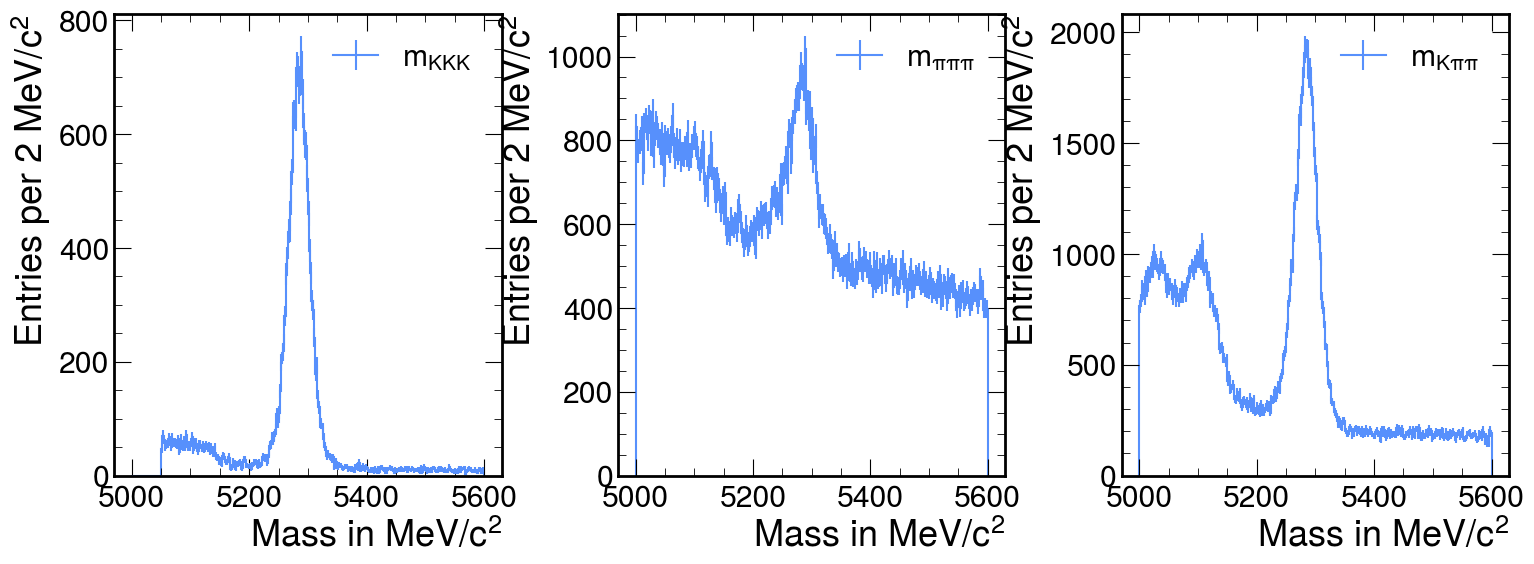

In [26]:
fig4, ax4 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig4.subplots_adjust(wspace=0.3)

hep.histplot(h_mKKK_narrow.GetPtr(), ax=ax4[0], histtype='step', label=r'$m_{KKK}$', linewidth=1.5)
hep.histplot(h_mpipipi_narrow.GetPtr(), ax=ax4[1], histtype='step', label=r'$m_{\pi\pi\pi}$', linewidth=1.5)
hep.histplot(h_mKpipi_narrow.GetPtr(), ax=ax4[2], histtype='step', label=r'$m_{K\pi\pi}$', linewidth=1.5)

ax4[0].set_xlabel('Mass in MeV/$c^2$')
ax4[0].set_ylabel('Entries per 2 MeV/$c^2$')
ax4[0].legend()
plt.savefig('../outputs/mKKK_narrow.pdf')
ax4[1].set_xlabel('Mass in MeV/$c^2$')
ax4[1].set_ylabel('Entries per 2 MeV/$c^2$')
ax4[1].legend()
plt.savefig('../outputs/mpipipi_narrow.pdf')
ax4[2].set_xlabel('Mass in MeV/$c^2$')
ax4[2].set_ylabel('Entries per 2 MeV/$c^2$')
ax4[2].legend()
plt.savefig('../outputs/mKpipi_narrow.pdf')

Fit results with chi2/ndf 315.8566678495421 / 188
Par 1: 2870.234850 +/- 784.998737
Par 2: 23.257757 +/- 6.028494
Par 3: 29910.828618 +/- 185.252472
Par 4: 5284.965107 +/- 0.103797
Par 5: 17.468757 +/- 0.110761
Par 6: 38.834395 +/- 6.953029
Par 7: 375.699054 +/- 81.741446
Fit results with chi2/ndf 281.77441944908514 / 200
Par 1: 9923.443619 +/- 1388.758690
Par 2: 28.114930 +/- 3.097864
Par 3: 21138.022149 +/- 636.890548
Par 4: 5282.579768 +/- 0.568294
Par 5: 21.936336 +/- 0.634295
Par 6: 697.273723 +/- 13.556605
Par 7: 1145.452028 +/- 69.862246
Fit results with chi2/ndf 374.71472705499804 / 200
Par 1: 43600.886920 +/- 1432.925184
Par 2: 27.829660 +/- 0.695860
Par 3: 76177.989653 +/- 546.601305
Par 4: 5284.661589 +/- 0.125179
Par 5: 18.803726 +/- 0.135347
Par 6: 471.786218 +/- 17.566581
Par 7: 477.659787 +/- 25.730815


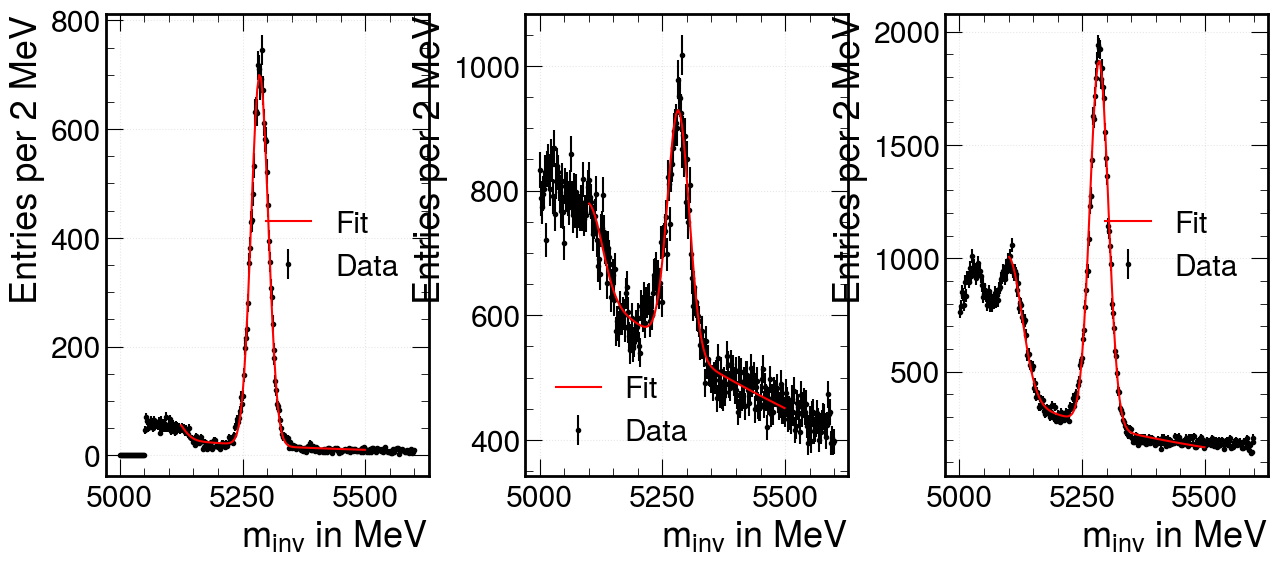

In [27]:
from scipy.optimize import curve_fit

# decaying exponential function
def exponential(x, norm, decay):
    return np.array( norm * np.exp(-(x-5000)/decay) )

# constant function
def constant(x, norm):
    return np.array( norm )

# Gaussian function
def gauss(x, norm, mu, sigma):
    return np.array( norm / np.sqrt(2*np.pi) / sigma * np.exp( -(x-mu)**2 / 2 / sigma**2 ) )

# fit function combining two individual functions
def fit_function(x, norm4, sigma4, normG, muG, sigmaG, normE, decay):
    return np.array( gauss(x, norm4, 5100, sigma4) + gauss(x, normG, muG, sigmaG) + exponential(x, normE, decay) )

def fit_data(hist_ptr, minX, maxX, p0):
    n_bins = hist_ptr.GetNbinsX()
    bin_centres = []
    values = []
    
    # Extract bin centers and values from the histogram
    for i in range(1, n_bins + 1):
        bin_center = hist_ptr.GetBinCenter(i)
        bin_content = hist_ptr.GetBinContent(i)
        bin_centres.append(bin_center)
        values.append(bin_content)
    
    # Reduce range to fit only part of curve
    bin_centres_red = []
    values_red = []
    for c, v in zip(bin_centres, values):
        if c < minX or c > maxX:
            continue
        bin_centres_red.append(c)
        values_red.append(v)
    
    # Execute the fit
    coeff_fit, cov_fit = curve_fit(fit_function, bin_centres_red, values_red, p0)
    fit_vals = [fit_function(x, coeff_fit[0], coeff_fit[1], coeff_fit[2], 
                            coeff_fit[3], coeff_fit[4], coeff_fit[5], coeff_fit[6]) 
                for x in bin_centres_red]
    
    # Calculate chi2
    chi2parts = np.array((np.divide(np.array(values_red) - np.array(fit_vals), 
                        np.sqrt(values_red), 
                        out=np.zeros_like(values_red), 
                        where=np.array(values_red) != 0))**2)  # Add small epsilon to avoid division by zero
    chi2 = np.sum(chi2parts)
    
    return coeff_fit, cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

def plot_results(ax, bin_centres, bin_centres_red, values, coeff_fit, fname):
    # Plot the data with error bars
    ax.errorbar(bin_centres, values, yerr=np.sqrt(np.array(values) + 1e-10), 
               linestyle='', marker='.', markerfacecolor='k', markeredgecolor='k', 
               ecolor='k', label='Data')
    
    # Plot the fit if successful
    if coeff_fit is not None and len(bin_centres_red) > 0:
        x_fit = np.linspace(bin_centres_red[0], bin_centres_red[-1], 100)
        y_fit = fit_function(x_fit, coeff_fit[0], coeff_fit[1], coeff_fit[2], 
                           coeff_fit[3], coeff_fit[4], coeff_fit[5], coeff_fit[6])
        ax.plot(x_fit, y_fit, label='Fit', color='r', zorder=10)
    
    # Plot decoration
    ax.legend()# 
    ax.set_xlabel(r'$m_{inv}$ in MeV')
    ax.set_ylabel('Entries per 2 MeV')
    ax.grid(True, alpha=0.3)
    plt.savefig(f"{fname}")

fig5, ax5 = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig5.subplots_adjust(wspace=0.3)

coeff_KKK_fit, cov_KKK_fit, bin_centres_KKK, bin_centres_red_KKK, chi2_KKK, ndf_KKK = \
    fit_data(h_mKKK_narrow.GetPtr(), 5125, 5500, [2000, 30, 30000, 5285, 20, 40, 500])
print_results(coeff_KKK_fit, cov_KKK_fit, chi2_KKK, ndf_KKK)
kkk_hist = h_mKKK_narrow.GetPtr()
values_KKK = [kkk_hist.GetBinContent(i) for i in range(1, kkk_hist.GetNbinsX() + 1)]
plot_results(ax5[0], bin_centres_KKK, bin_centres_red_KKK, values_KKK, coeff_KKK_fit, '../outputs/mfit_KKK.pdf')

coeff_pipipi_fit, cov_pipipi_fit, bin_centres_pipipi, bin_centres_red_pipipi, chi2_pipipi, ndf_pipipi = \
    fit_data(h_mpipipi_narrow.GetPtr(), 5100, 5500, [8000, 30, 10000, 5285, 20, 1000, 500])
print_results(coeff_pipipi_fit, cov_pipipi_fit, chi2_pipipi, ndf_pipipi)
pipipi_hist = h_mpipipi_narrow.GetPtr()
values_pipipi = [pipipi_hist.GetBinContent(i) for i in range(1, pipipi_hist.GetNbinsX() + 1)]
plot_results(ax5[1], bin_centres_pipipi, bin_centres_red_pipipi, values_pipipi, coeff_pipipi_fit, '../outputs/mfit_pipipi.pdf')

coeff_Kpipi_fit, cov_Kpipi_fit, bin_centres_Kpipi, bin_centres_red_Kpipi, chi2_Kpipi, ndf_Kpipi = \
    fit_data(h_mKpipi_narrow.GetPtr(), 5100, 5500, [15000, 30, 60000, 5285, 20, 400, 500])
print_results(coeff_Kpipi_fit, cov_Kpipi_fit, chi2_Kpipi, ndf_Kpipi)
kpi_hist = h_mKpipi_narrow.GetPtr()
values_Kpipi = [kpi_hist.GetBinContent(i) for i in range(1, kpi_hist.GetNbinsX() + 1)]
plot_results(ax5[2], bin_centres_Kpipi, bin_centres_red_Kpipi, values_Kpipi, coeff_Kpipi_fit, '../outputs/mfit_Kpipi.pdf')

plt.show()

In [28]:
end_time = time.time()
elapsed = end_time - start_time
minutes = int(elapsed // 60)
seconds = int(elapsed % 60)
print(f"Total execution time: {minutes} min {seconds} sec")

Total execution time: 1 min 58 sec
